In [1]:
import pyidi
import importlib
import os
import pickle
from sdypy import EMA
import numpy as np
import matplotlib.pyplot as plt 
from pixel_setter2 import PixelSetter
from scipy.signal import find_peaks
from pixel_setter import play_video
from scipy.spatial.distance import cdist
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
import pixel_setter
from pixel_setter import animate_mode_shape
import math
from scipy import stats
%matplotlib inline

c:\Users\thijs\anaconda3\lib\site-packages\skimage\util\dtype.py:27: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  np.bool8: (False, True),


### Import displacement data

In [2]:
# root_disp = 'C:/Users/thijs/Documents/GitHub/pyidi_data/displacements'
# root_disp = 'C:/Users/thijsmas/Documents/GitHub/pyidi_data/'
root_disp = os.path.normpath('G:/.shortcut-targets-by-id/1k1B8zPb3T8H7y6x0irFZnzzmfQPHMRPx/Illimited Lab Projects/Spiders/Simulations')
root_drive_sim = os.path.normpath('G:/.shortcut-targets-by-id/1k1B8zPb3T8H7y6x0irFZnzzmfQPHMRPx/Illimited Lab Projects/Spiders/Simulations')
folder_paths = ['D:/HSC', 'F:/', 'C:/Users/thijs/Documents/HSC/', 'H:/My Drive/PHD/HSC']  #, 'H:/My Drive/PHD/HSC'
root_impact = os.path.normpath('H:/My Drive/PHD/Data')


file_name_basis = 'Full_web_ecc0_new_Floc4_v1'
file_name_displacement = file_name_basis + '_d'
extension = '.pkl'
path = os.path.join(root_disp, 'displacements', file_name_displacement + extension)

# Open displacement data
with open(path, 'rb') as f:
    # load the pickle data
    data = pickle.load(f)

# Open corresponding video
file_name_video = file_name_basis + "_S01.cihx"
for folder_path in folder_paths:
    for root, dirs, files in os.walk(folder_path, topdown=False):
        if file_name_video in files:
            file_path = os.path.join(root, file_name_video)
            print(file_path)
            break
video = pyidi.pyIDI(file_path)
fs_camera = video.info['Record Rate(fps)']
t_camera = np.arange(video.info['Total Frame']) / fs_camera
video.info

H:/My Drive/PHD/HSC\ecc0\web0\Full_web_ecc0_new_Floc4_v1_S01\Full_web_ecc0_new_Floc4_v1_S01.cihx


c:\Users\thijs\anaconda3\lib\site-packages\pyMRAW.py:103: UserWarning: Clipped footage! (Total frame: 10000, Original total frame: 87371)
  warnings.warn('Clipped footage! (Total frame: {}, Original total frame: {})'.format(cih['Total Frame'], cih['Original Total Frame'] ))


{'Date': '2023/9/16',
 'Camera Type': 'FASTCAM SA-Z type 2100K-M-64GB',
 'Record Rate(fps)': 8000.0,
 'Shutter Speed(s)': 8104.0,
 'Total Frame': 10000,
 'Original Total Frame': 87371,
 'Image Width': 1024,
 'Image Height': 512,
 'File Format': 'Mraw',
 'EffectiveBit Depth': 12,
 'EffectiveBit Side': 'Higher',
 'Color Bit': 16,
 'Comment Text': ''}

### Import corresponding impact hammer data

In [3]:
files = os.listdir(root_impact)
for file in files:
    if file_name_basis in file[16:-4]:
        path = os.path.join(root_impact, file)
        with open(path, 'rb') as f:
            impact_data = pickle.load(f)
        break
else:
    print(f"{file_name_basis} is not in files")

### Play video

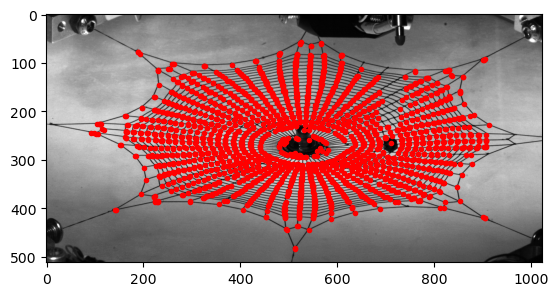

In [4]:
%matplotlib inline
tp_lim = data['tracking points']
low_amplitude = np.max(np.linalg.norm(data['displacement'], axis=2),1)<25
td = data['displacement'] +  tp_lim.reshape(len(tp_lim),1,2)

if 'broken_ids_set' in locals():
    # broken ids: {930, 1220, 1417, 109, 977, 370, 469, 664, 1883, 1663}
    low_amplitude[nan_indices]  = False
    low_amplitude[list(broken_ids_set)]   = False
ani = play_video(video, range(1,9999), interval=30, points=td[low_amplitude, :, :])
# ani = play_video(video, range(1,9999), interval=30)
# writer = animation.FFMpegWriter(fps=60)
# ani.save(os.path.join(root_disp,'anim',file_name_basis+'_anim.mp4'), writer=writer)


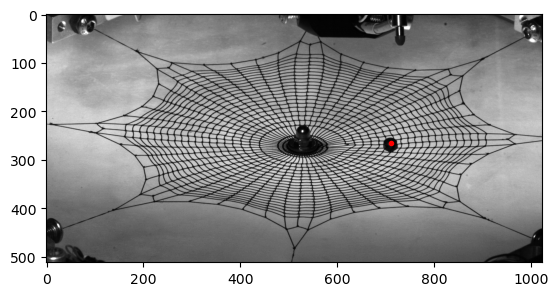

In [5]:
point = [265, 710 ]  # replace x and y with the coordinates of the point
# calculate the distances between the point and all points in tp_lim
distances = cdist([point], tp_lim)
# find the index of the nearest point
nearest_index = np.argmin(distances)
# get the coordinates of the nearest point
nearest_point = tp_lim[nearest_index]
ani = play_video(video, range(1,5000), interval=30, points=td[nearest_index, :, :].reshape(1,-1,2)); #tp[biggest_outliers, :, :].reshape(1,-1,2) np.repeat(tp_lim[biggest_outliers, np.newaxis, :], 7000, axis=1)

### Define displacement, acceleration and force signals

In [6]:
fs_force = impact_data['NI']['sample_rate']
force_index = impact_data['NI']['channel_names'].index('Force')
accel_index = impact_data['NI']['channel_names'].index('Acceleration')
force = impact_data['NI']['data'][:,force_index]
accel = impact_data['NI']['data'][:,accel_index]

start_index = np.where(impact_data['NI']['time'] >= 1.5)[0][0]

impact_mean = np.mean(force[start_index:])
mean_accel = np.mean(accel[start_index:])

force -= impact_mean
accel = -(accel-mean_accel)/9.81

disp = data['displacement'][:, :, 0]
disp_nut = data['displacement'][nearest_index, :, 0]


### Prepare the signals
- Allign impact with the point where nut starts moving
- Add n zeros before signals against leakage
- clip signals such that they end at exact same time point
- Zero all the force except the impact

In [7]:
# Add some zeros before the impact to reduce leakage. Due to the different sampling frequencies, the first common denominator is found and the number of zeros is calculated from there.
frames_per_gcd      = int(fs_camera / math.gcd(int(fs_camera), int(fs_force)))
n_zeros_before_cam  = frames_per_gcd
n_zeros_before_for  = int(n_zeros_before_cam * fs_force / fs_camera)

# Find the peaks in the displacement signal. 
disp_peaks, _       = find_peaks(disp_nut, height=0.5, distance=fs_camera*0.01)
threshold           = 0.001
near_zero_indices_cam   = np.where(disp_nut[:disp_peaks[0]] < threshold)[0]
first_cam_near_zero_index = near_zero_indices_cam[-1]

# Shift the time signal such that the impact - n_zeros_before_cam is at t=0, 
t_camera2           = np.round(t_camera - t_camera[first_cam_near_zero_index-n_zeros_before_cam], 7)
# Clip the time
time_cam_clipped    = t_camera2[first_cam_near_zero_index-n_zeros_before_cam:]
disp_nut_clipped    = disp_nut[first_cam_near_zero_index-n_zeros_before_cam:]
disp_clipped        = disp[:, first_cam_near_zero_index-n_zeros_before_cam:]
disp_clipped[:n_zeros_before_cam] = 0


# Prepare Force signal
force_peaks, _      = find_peaks(force, height=0.5)
threshold           = 0.001
near_zero_indices_for   = np.where(force[:force_peaks[0]] < threshold)[0]
first_for_near_zero_index = near_zero_indices_for[-1]
near_zero_indices_for_after   = (np.where(force[force_peaks[0]+1:force_peaks[0]+10] < threshold)[0]) + force_peaks[0]+1
first_for_near_zero_index_after = near_zero_indices_for[0]
t_force             = np.round(impact_data['NI']['time'] - impact_data['NI']['time'][first_for_near_zero_index - n_zeros_before_for],7)
t_force_index_end   = np.argmin(np.abs(t_force - t_camera2[-1]))

time_force_clipped    = t_force[first_for_near_zero_index- n_zeros_before_for:t_force_index_end]
force_clipped       = force[first_for_near_zero_index- n_zeros_before_for:t_force_index_end]

# Cut off signals such that they end at the same time. Loop is because sample ratios 
for i in range(1, frames_per_gcd+2): 
    if time_cam_clipped[-i] in time_force_clipped:
        index = np.where(time_cam_clipped[-i] == time_force_clipped)[0][0]
        time_cam_clipped = time_cam_clipped[:-i+1]
        disp_nut_clipped = disp_nut_clipped[:-i+1]
        disp_clipped = disp_clipped[:, :-i+1]
        time_force_clipped = time_force_clipped[:index+1]
        force_clipped = force_clipped[:index+1]
        break
print(time_cam_clipped[-1], time_force_clipped[-1])

# Zero the force signal around the impact (The rest is all noise)
force_clipped_mod = np.copy(force_clipped)
force_clipped_mod[force_clipped_mod < 0.1] = 0

1.221875 1.221875


### Plot raw and modified force signal

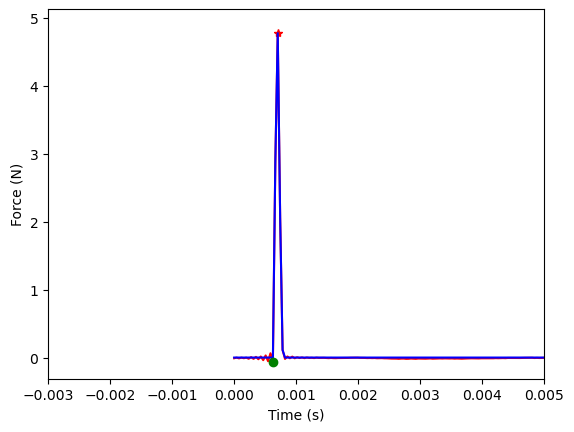

In [8]:

fig, ax = plt.subplots()
ax.plot(time_force_clipped, force_clipped,'r-')
ax.plot(t_force[force_peaks], force[force_peaks],'r*')
ax.plot(time_force_clipped, force_clipped_mod,'b-')
ax.plot(t_force[first_for_near_zero_index], force[first_for_near_zero_index],'go')
ax.plot(t_force[first_for_near_zero_index_after], force[first_for_near_zero_index_after],'ro')
ax.set_xlim([-0.003, 0.005])
plt.xlabel('Time (s)')
plt.ylabel('Force (N)')
plt.show()


### Plot signals

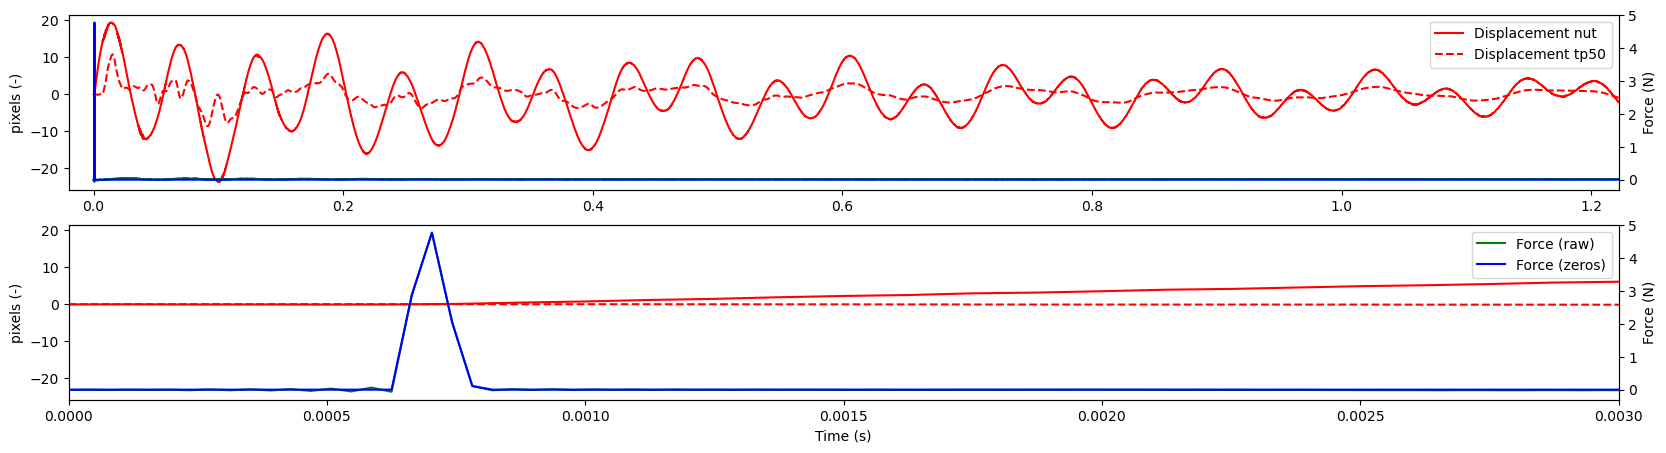

In [9]:
tp_id = 50
fig, ax = plt.subplots(2,1,figsize=(20,5))
ax0_2 = ax[0].twinx()
ax1_2 = ax[1].twinx()
ax0_2.plot(time_force_clipped, force_clipped,'g-', label='Force (raw))')
ax0_2.plot(time_force_clipped, force_clipped_mod,'b-', label='Force (zeros)')
ax[0].plot(time_cam_clipped, disp_nut_clipped,'r-', label='Displacement nut')
ax[0].plot(time_cam_clipped, disp_clipped[tp_id,:],'r--', label=f'Displacement tp{tp_id}')
ax[0].set_xlim([-0.02, time_cam_clipped[-1]])

ax[0].set_ylabel('pixels (-)')
ax0_2.set_ylabel('Force (N)')
ax[0].legend(loc='upper right')


ax1_2.plot(time_force_clipped, force_clipped,'g-', label='Force (raw)')
ax1_2.plot(time_force_clipped, force_clipped_mod,'b-', label='Force (zeros)')
ax[1].plot(time_cam_clipped, disp_nut_clipped,'r-', label='Displacement nut')
ax[1].plot(time_cam_clipped, disp_clipped[tp_id,:],'r--', label=f'Displacement tp{tp_id}')
# ax[1].plot(t_camera2[disp_peaks], disp_nut[disp_peaks], 'rx')
ax[1].set_xlim([0, 0.003])
ax[1].set_ylabel('pixels (-)')
ax1_2.set_ylabel('Force (N)')

# set legend to north east
ax1_2.legend()
ax[1].set_xlabel('Time (s)')
plt.show()
fig.savefig(os.path.join(root_drive_sim, 'signals', 'example impact 2'))
fig.savefig(os.path.join(root_drive_sim, 'signals', 'example impact'))

### Define frequency spectrum
Set padding here (set to 1 for pole selction)

In [10]:
extension_ratio = 1

n_d = len(disp_nut_clipped)
n_f = len(force_clipped)
n_d, n_f

n_d = int(np.ceil(n_d*extension_ratio))
n_f = int(np.ceil(n_f*extension_ratio))    

freq_camera = np.fft.rfftfreq(n_d, 1/fs_camera)
freq_force = np.fft.rfftfreq(n_f, 1/fs_force)
freq_camera[1], freq_force[1]

(0.8183306055646481, 0.8183881589463252)

In [11]:
Disp = np.fft.rfft(disp_clipped, n=n_d) / n_d
Force = np.fft.rfft(force_clipped_mod, n=n_f) / n_f

# Normalize the one-sided amplitude spectra:
Disp[ 1:] *= 2
Force[1:] *= 2
Disp.shape, Force.shape

((2155, 4889), (15641,))

In [12]:
n_freq = len(freq_camera)
freq_force = freq_force[:n_freq]

Disp = Disp[:n_freq]
Force = Force[:n_freq]

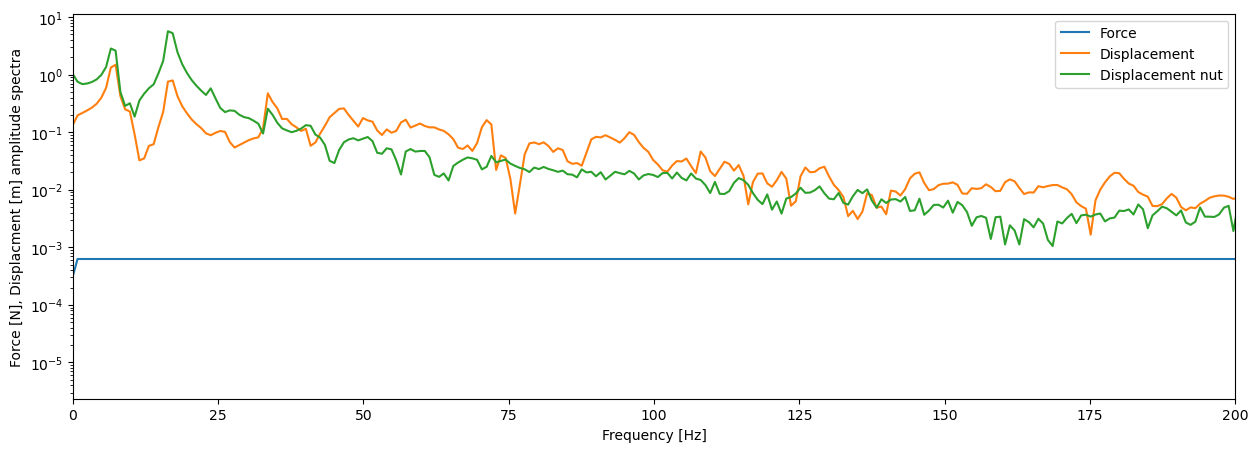

In [13]:
plt.figure(figsize=(15, 5))
plt.semilogy(freq_force, np.abs(Force), label='Force')
plt.semilogy(freq_camera, np.abs(Disp[tp_id]), label='Displacement')
# plt.semilogy(freq_camera, np.abs(Disp[tp_id])/ np.abs(Force), label='output/input')
plt.semilogy(freq_camera, np.abs(Disp[nearest_index]), label='Displacement nut')
plt.xlim(0, 200)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Force [N], Displacment [m] amplitude spectra')
plt.legend()

In [14]:
T = time_force_clipped[-1] # acquisition period

S_xx = 1/T * np.conj(Disp) * Disp
S_ff = 1/T * np.conj(Force) * Force
S_xf = 1/T * np.conj(Disp) * Force
S_fx = 1/T * np.conj(Force) * Disp

H_1_cam = S_fx / S_ff
H_2_cam = S_xx / S_xf
H_v_cam = (H_1_cam * H_2_cam)**0.5


# calculate z-scores for H_1_cam
z_scores = stats.zscore(H_1_cam, axis=0)
z_scores = np.mean(np.abs(z_scores), axis=1)
biggest_outliers = np.where(z_scores > 1)[0]
# biggest_outliers = np.argsort(z_scores)[-5:]

C:\Users\thijs\AppData\Local\Temp\ipykernel_24968\1202321286.py:9: RuntimeWarning: invalid value encountered in divide
  H_2_cam = S_xx / S_xf


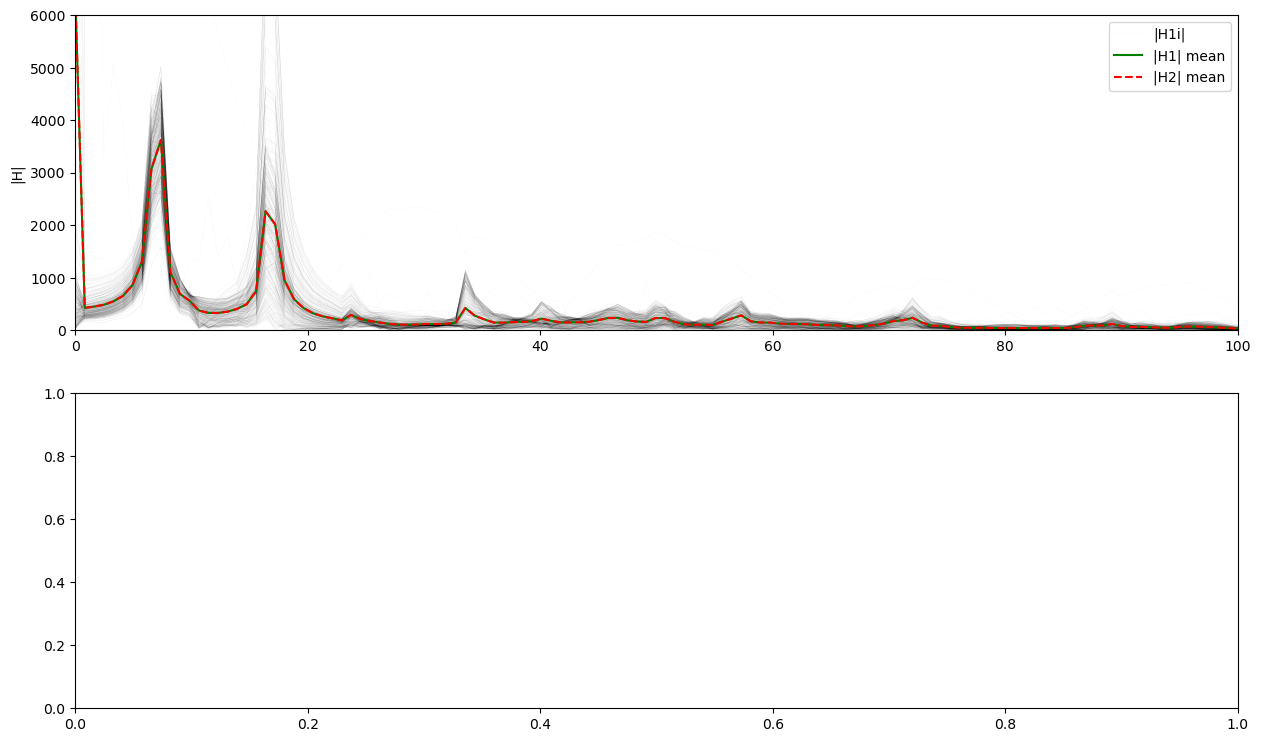

In [26]:
fig, ax = plt.subplots(2,1,figsize=(15, 9))
# plt.plot(freq_force, np.abs(H_1_cam[tp_id]), 'r', label=f'H1 tp#{tp_id}')
# plt.plot(freq_force, np.abs(H_2_cam[tp_id]), 'b:', label=f'H2 tp#{tp_id}')
for tp_id in range(0, len(tp_lim),5):
    if tp_id == 0:
        ax[0].plot(freq_camera, np.abs(H_1_cam[tp_id]), 'k', linewidth=0.1, alpha=0.1, label='|H1i|')
    else:
        ax[0].plot(freq_camera, np.abs(H_1_cam[tp_id]), 'k', linewidth=0.1, alpha=0.1)
# for i, tp_id in enumerate(biggest_outliers):
#     if i == 0:
#         ax[0].semilogy(freq_camera, np.abs(H_1_cam[tp_id]), 'r', linewidth=0.2, alpha=0.5, label='Outlier')
#     else:
#         ax[0].semilogy(freq_camera, np.abs(H_1_cam[tp_id]), 'r', linewidth=0.2, alpha=0.5)
ax[0].plot(freq_force, np.mean(np.abs(np.delete(H_1_cam, biggest_outliers, axis=0)), axis=0),'g', label='|H1| mean')
ax[0].plot(freq_force, np.mean(np.abs(np.delete(H_1_cam, biggest_outliers, axis=0)), axis=0), 'r--', label='|H2| mean')
ax[0].set_ylabel('|H|')
ax[0].set_xlim(0, 100)
ax[0].set_ylim(0, 6000)
ax[0].legend()

# phase_H1 = np.delete(np.angle(H_1_cam), biggest_outliers, axis=0)
# phase_H2 = np.delete(np.angle(H_2_cam), biggest_outliers, axis=0)
# un_min = np.min(phase_H1)
# un_max = np.max(phase_H1)
# for tp_id in range(0,len(tp_lim)-1,20):
#     unwrapped = np.unwrap(phase_H1[tp_id])
#     un_min = np.min([un_min, np.min(unwrapped)])
#     un_max = np.max([un_max, np.max(unwrapped)])

#     if tp_id == 0:
#         ax[1].plot(freq_force, unwrapped, 'k--', linewidth=1, alpha=0.1, label=f'angle H1')
#         # ax[1].plot(freq_force, np.delete(phase_H2[tp_id], biggest_outliers, axis=0), 'r--', label=f'angle H2')
#     else:
#         ax[1].plot(freq_force, unwrapped, 'k--', linewidth=1, alpha=0.1)
        

# ax[1].set_xlabel('Frequency [Hz]')
# ax[1].set_ylabel('angle H [rad]')
# ax[1].set_xlim(0, 200)
# ax[1].set_ylim(np.min(unwrapped), np.max(unwrapped))
# ax[1].legend()
plt.savefig(os.path.join(root_disp,'FRFs',f'FRF_zero_padding_multiplier{extension_ratio}2.png'))




In [30]:
cam = EMA.Model(np.delete(H_1_cam, biggest_outliers, axis=0), freq_camera, lower=3, upper=100, pol_order_high=100)
# cam2 = EMA.Model(H_1_cam, freq_camera, lower=5, upper=100, pol_order_high=100)

In [31]:
cam.get_poles(show_progress=True)
# cam2.get_poles(show_progress=True)

100%|█████████████████████████████████████████████████████████████| 100/100 [00:34<00:00,  2.87it/s]


In [32]:
cam.select_poles()
# cam.select_closest_poles([6.999515663186072,
#  9.717650538299283,
#  16.6755382729788,
#  17.062357782278475,
#  23.921275967944748,
#  33.79594201938932,
#  40.51486694015743,
#  46.315743863692504,
#  50.412021819772356,
#  57.018602925509015,
#  70.43413543450502,
#  72.06367326983168,
#  86.94618105617842,
#  89.24102877104337,
#  95.8522886461724,
#  104.71185570063557,
#  107.95465726494655,
#  112.06077990834342,
#  114.9936646923656,
#  122.26511109622977,
#  133.67179476123184,
#  141.88440418618666,
#  144.96584376423692,
#  151.47969419412365,
#  156.05583127441116,
#  160.8310929063179,
#  173.1488843879467,
#  179.59888942710995])
# cam.FRF_reconstruct
# cam2.select_poles()

100%|████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 106.74it/s]


<Figure size 640x480 with 0 Axes>

In [33]:
cam.print_modal_data()

   Nat. f.      Damping
-----------------------
1)    7.0	0.0197
2)    9.7	0.0357
3)   14.0	0.0190
4)   16.7	0.0117
5)   25.0	0.0121
6)   26.8	0.0130
7)   34.0	0.0088
8)   37.2	0.0222
9)   39.4	0.0112
10)   40.4	0.0131
11)   46.4	0.0278
12)   47.3	0.0122
13)   50.2	0.0101
14)   51.4	0.0138
15)   54.2	0.0128
16)   55.8	0.0130
17)   57.2	0.0093
18)   58.7	0.0066
19)   59.8	0.0174
20)   62.4	0.0219
21)   64.8	0.0064
22)   70.5	0.0095
23)   72.1	0.0087
24)   73.7	0.0058
25)   77.8	0.0086
26)   77.8	0.0086
27)   79.1	0.0072
28)   80.4	0.0060
29)   84.7	0.0054
30)   87.0	0.0058
31)   89.1	0.0066
32)   90.4	0.0071
33)   91.7	0.0064
34)   95.9	0.0067
35)   97.1	0.0101


In [ ]:
A = np.imag(cam.A ) #,/ np.linalg.norm(cam.A, axis=0)
y_shift = (1024-768)/2
n_modes = len(cam.nat_freq) #1 #
broken_ids_set = set([])
for mode_number in range(n_modes):
    fig, ax = plt.subplots(subplot_kw={'projection': '3d'}, figsize=(15, 15))
    n_del = 30
    nan_indices = np.where(np.isnan(A[:,mode_number]))[0]
    not_nan_indices = np.where(~np.isnan(A[:,mode_number]))[0]

    lower_bound = np.percentile(np.abs(A[not_nan_indices,mode_number]), 5)
    upper_bound = np.percentile(np.abs(A[not_nan_indices,mode_number]), 95)
    values_within_bounds = A[(np.abs(A[:,mode_number]) >= lower_bound) & (np.abs(A[:,mode_number]) <= upper_bound), mode_number]
    mean_within_bounds = np.mean(values_within_bounds)

    A[:,mode_number] -= mean_within_bounds

    broken_ids = np.where(np.abs(A[:,mode_number]) >= 5)[0]
    broken_ids_set = broken_ids_set.union(set(broken_ids))
    multiplier = -1
    indices_to_plot = list(set(range(len(A))) - broken_ids_set)
    ax.plot(tp_lim[indices_to_plot,1], -tp_lim[indices_to_plot,0], np.zeros_like(tp_lim[indices_to_plot,0]), 'k.', markersize=1)
    ax.plot(tp_lim[indices_to_plot,1], -tp_lim[indices_to_plot,0], multiplier*A[indices_to_plot,mode_number], 'r.', markersize=1)
    # ax.plot(tp_lim[broken_ids,1], -tp_lim[broken_ids,0], multiplier*A[broken_ids,mode_number], 'b.', markersize=1)
    
    plt.xlim([0, 1024])
    plt.ylim([-768-y_shift, 0+y_shift])
    ax.set_zlabel('Normalized Mode Shape')
    ax.view_init(elev=30, azim=-90)
    plt.tight_layout()
    fig.savefig(os.path.join(root_disp,'mode_shapes',f'Mode_shape_init_{mode_number}_v1.png'))
    plt.close()
# plt.show()

print(f'broken_ids_set: {broken_ids_set}')

In [51]:
%matplotlib qt
n_modes = len(cam.nat_freq)
importlib.reload(pixel_setter)
from pixel_setter import animate_mode_shape
tp_lim_sel = np.delete(tp_lim, biggest_outliers, axis=0)
indices_to_plot = list(set(range(len(cam.A)))) # - set(biggest_outliers)  - broken_ids_set
for mode_number in range(14,n_modes): #[22]: # 
    print(f'mode_number: {mode_number}')
    ani = animate_mode_shape(cam, mode_number, tp_lim_sel, 1, indices_to_plot = indices_to_plot) #, indices_to_plot = indices_to_plot np.delete(tp_lim, biggest_outliers, axis=0)
    writer = animation.FFMpegWriter(fps=60)
    ani.save(os.path.join(root_drive_sim,'web mode shapes', f'Mode_shape_init_{mode_number}_v7.mp4'), writer=writer)
    plt.close()


mode_number: 14
mode_number: 15
mode_number: 16
mode_number: 17
mode_number: 18
mode_number: 19
mode_number: 20
mode_number: 21
mode_number: 22
mode_number: 23
mode_number: 24
